In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from collections import defaultdict

In [2]:
import sklearn
sklearn.__version__

'1.7.2'

## Калибровка уверенности классификатора

Давайте рассмотрим, как визуализировать, насколько хорошо наш классификатор откалиброван для предсказанния вероятности. 

Пройдем весь путь по шагам.

### Немного теории

1. Непараметрический метод гистограммной калибровки (Histogram Binning)

$$\sum_{i=1}^{k}\sum_{b(x)\in B_i} (\theta_i -y(x))^2 \to \min$$

Цель привести центы бинов на пунктирную линию. Изначально в методе использовались бины одинаковой ширины (но можно использовать и равномощные). После решения задачи, если оценка принадлежности к классу попала в $i$-й бин, её заменяют на соответствующее значение $θ_i$. Минусы такого подхода:
- число бинов задаётся изначально,
- нет непрерывности у функции деформации,
- в «равноширном варианте» в некоторых бинах содержится малое число точек.
  
2. Непараметрический метод – изотонная регрессия (Isotonic Regression)

Строится монотонно неубывающая функция деформации оценок алгоритма. По сути, решается такая же задача оптимизации, как и в методе 1, но есть дополнительное условие:
            $$\theta_1\leq ... \leq \theta_k$$
По-прежнему, функция деформации не является непрерывной.

3. Параметрическая калибровка Платта (Platt calibration)

   Изначально метод разрабатывался для SVM (кстати там и используется в `predict_proba`), оценки которого лежат на вещественной оси (по сути, это расстояния до оптимальной разделяющей классы прямой, взятые с нужным знаком), считается, что метод не очень подходит для других моделей (хотя имеет много обобщений).
   Пусть алгоритм выдаёт расстояние со знаком до разделяющей поверхности $r(x)$, ищем решение как:
   $$ b_{new}(x) = \text{sigmoid}(\alpha\dot r(x)+\beta)$$


и есть еще несколько варианово, даже на основе деревьев.

Однако в `scikit-learn` реализованы только изотонная регрессия и калибровка Платта. Полный обзор остальных вариантов можно найти [тут](https://alexanderdyakonov.wordpress.com/2020/03/27/проблема-калибровки-уверенности/)


### Демонстрационный датасет

Мы будем использовать синтетический набор данных бинарной классификации со 100 000 выборками
и 20 функций. Из 20 функций только 2 являются информативными, 2 -
избыточными (случайные комбинации информативных функций) и
оставшиеся 16 неинформативны (случайные числа).

Из 100 000 образцов 100 будут использованы для подбора модели, а остальные
для тестирования. 

Обратите внимание, что подход не является стандартным и его цель состоит в том, чтобы получить
стабильные оценки калибровочной кривой для моделей, которые потенциально подвержены
переобучению. 

На практике лучше использовать перекрестную проверку с большим количеством
сбалансированных разделений, но это сделало бы код в этом примере более сложным
для понимания.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

In [4]:
lr = LogisticRegressionCV(Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

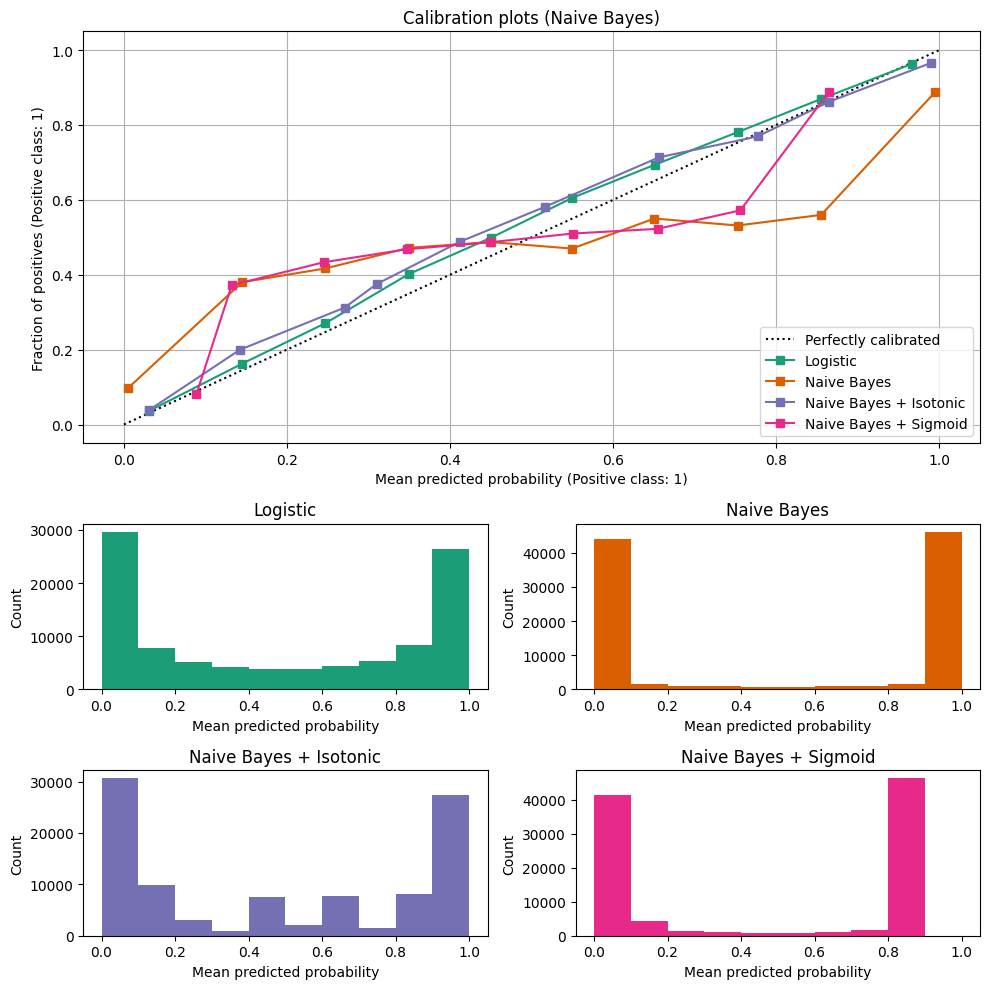

In [5]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

Некалиброванный `GaussianNB` плохо откалиброван из-за избыточных признаков, которые нарушают предположение о независимости признаков и приводят к чрезмерно уверенному классификатору, на что указывает типичная сигмовидная кривая. 

Калибровка вероятностей гауссовой регрессии с помощью изотонической регрессии позволяет устранить эту проблему, как видно из калибровочной кривой, близкой к диагонали. 

Калибровка Платта также немного улучшает калибровку, хотя и не так сильно, как непараметрическая изотоническая регрессия. Это можно объяснить тем фактом, что у нас есть большое количество калибровочных данных, которые позволяют использовать большую гибкость непараметрической модели.

In [6]:
from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.098104,0.319408,0.938190,0.873290,0.851954,0.862490
Naive Bayes,0.117608,0.782755,0.940374,0.857400,0.875941,0.866571
Naive Bayes + Isotonic,0.098332,0.370738,0.938613,0.883065,0.836224,0.859007
Naive Bayes + Sigmoid,0.108880,0.368896,0.940201,0.861106,0.871277,0.866161


Что такое `Brier loss` - оценка Брайера (BS) — это правило оценки, измеряющее квадрат ошибки между предсказанным вектором вероятности и истинной меткой, закодированной прямым унитарным кодом. Более низкие баллы соответствуют более точной калибровке. Интуитивно BS измеряет точность предсказанных вероятностей. Его можно разложить на три компонента — неопределенность, разрешение и надежность.Хотя BS является хорошей метрикой для измерения калибровки прогнозов модели, она нечувствительна к вероятностям, связанным с нечастыми событиями. </br>
Таким образом, полезно использование нескольких показателей в дополнение к BS для оценки калибровки.